In [1]:
import pandas as pd
import numpy as np 
# import plotly
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.probability import FreqDist
from os import path 
from PIL import Image 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline


In [2]:
'''
Issues: 
1. case number = permit number. What is the point of keeping both of them.
2. what is prop_use and existing_use? It is different in API and CSV file
3. last three columns are 2010 Census Neighborhoods, 2010 Census Wards Precincts, and Zipcode, which are different from the API calling
4. what is the point of keeping column 'property_address'
5. Is there a list of work type as a reference? 
'''
# permit_data = 'https://data.baltimorecity.gov/resource/fesm-tgxf.csv'
# house_permit_api = pd.read_csv(permit_data,dtype = 'unicode')

"\nIssues: \n1. case number = permit number. What is the point of keeping both of them.\n2. what is prop_use and existing_use? It is different in API and CSV file\n3. last three columns are 2010 Census Neighborhoods, 2010 Census Wards Precincts, and Zipcode, which are different from the API calling\n4. what is the point of keeping column 'property_address'\n5. Is there a list of work type as a reference? \n"

# Data Cleaning

In [3]:
# Get the price data
house_price_raw = pd.read_excel('RealProp_4_28_20.xlsx')

In [4]:
house_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238424 entries, 0 to 238423
Data columns (total 80 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   OBJECTID       238424 non-null  int64  
 1   PIN            238424 non-null  object 
 2   PINRELATE      238424 non-null  object 
 3   BLOCKLOT       238424 non-null  object 
 4   BLOCK          238424 non-null  object 
 5   LOT            238424 non-null  object 
 6   WARD           238424 non-null  int64  
 7   SECTION        238424 non-null  int64  
 8   ASSESSOR       238424 non-null  object 
 9   TAXBASE        238424 non-null  int64  
 10  BFCVLAND       132111 non-null  float64
 11  BFCVIMPR       238424 non-null  int64  
 12  LANDEXMP       238424 non-null  int64  
 13  IMPREXMP       238424 non-null  int64  
 14  CITYCRED       234220 non-null  float64
 15  STATCRED       238424 non-null  float64
 16  CCREDAMT       238424 non-null  float64
 17  SCREDAMT       238181 non-nul

In [5]:
house_price_filter = house_price_raw.filter(items = ['PIN','BLOCK','LOT','TAXBASE','FULLCASH'])
house_price_filter['VALUE'] = house_price_filter['TAXBASE'] + house_price_filter['FULLCASH']
house_price_filter.head(100)

,PIN,BLOCK,LOT,TAXBASE,FULLCASH,VALUE
0,0001001,0001,001,141800,0,141800
1,0001002,0001,002,49500,0,49500
2,0001003,0001,003,7000,0,7000
3,0001004,0001,004,7000,0,7000
4,0001005,0001,005,21667,0,21667
...,...,...,...,...,...,...
95,0002043,0002,043,5333,0,5333
96,0002044,0002,044,6000,0,6000
97,0002045,0002,045,5333,0,5333
98,0002046,0002,046,36667,0,36667


In [6]:
house_permit_from_file = pd.read_csv('Housing_Permits.csv',dtype = 'unicode')
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634950 entries, 0 to 634949
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   PermitID                     634950 non-null  object
 1   CaseNum                      634950 non-null  object
 2   Block                        634947 non-null  object
 3   Lot                          634947 non-null  object
 4   PropertyAddress              634882 non-null  object
 5   PermitNum                    634950 non-null  object
 6   DateIssue                    634950 non-null  object
 7   PermitDescription            615005 non-null  object
 8   Cost_Est                     468980 non-null  object
 9   DateExpire                   577165 non-null  object
 10  Prop_Use                     582264 non-null  object
 11  Existing_Use                 582436 non-null  object
 12  Neighborhood                 611060 non-null  object
 13  PoliceDistrict

In [7]:
# Question 1 What types of construction permits are people pulling?
house_permit_from_file['PermitDescription'] = house_permit_from_file['PermitDescription'].astype(str)
house_permit_from_file['Location'] = house_permit_from_file['Location'].astype(str)
house_permit_from_file = house_permit_from_file[house_permit_from_file['PermitDescription'].notnull()]


In [8]:
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634950 entries, 0 to 634949
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   PermitID                     634950 non-null  object
 1   CaseNum                      634950 non-null  object
 2   Block                        634947 non-null  object
 3   Lot                          634947 non-null  object
 4   PropertyAddress              634882 non-null  object
 5   PermitNum                    634950 non-null  object
 6   DateIssue                    634950 non-null  object
 7   PermitDescription            634950 non-null  object
 8   Cost_Est                     468980 non-null  object
 9   DateExpire                   577165 non-null  object
 10  Prop_Use                     582264 non-null  object
 11  Existing_Use                 582436 non-null  object
 12  Neighborhood                 611060 non-null  object
 13  PoliceDistrict

In [9]:
# Create PIN in house_permit form
house_permit_from_file['Block'] = house_permit_from_file['Block'].str.zfill(4)
house_permit_from_file['Lot'] = house_permit_from_file['Lot'].str.zfill(3)
house_permit_from_file['PIN'] = house_permit_from_file['Block'] + house_permit_from_file['Lot']
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,Prop_Use,Existing_Use,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,ASM,ASM,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,NaN,1-05,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,SF,VAC,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B
3,20191219115630173B,COM2019-88415,1732,042,3126 E BALTIMORE ST,COM2019-88415,12/26/2019,scope of work: interior alterations to include...,15000.00,06/26/2020,1-05,1-05,BALTIMORE-LINWOOD,Southeastern,1,"3126 E BALTIMORE ST\nBaltimore, MD\n(39.292363...",9,118,27935,1732042
4,20191226094441660W,COM2019-88825,0503,012,222 W READ ST,COM2019-88825,12/26/2019,amend to add electrical contractor: (original ...,NaN,06/26/2020,3-42,3-42,MID-TOWN BELVEDERE,Central,11,"222 W READ ST\nBaltimore, MD\n(39.30066, -76.6...",165,93,13642,0503012


In [10]:
# Since pandas dataframe would store the address of the string, it would always show strings as object. Remeber to use .str to refer to it 
house_permit_from_file['Location_list'] = house_permit_from_file['Location'].str.split()
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,...,Existing_Use,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN,Location_list
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,...,ASM,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014,"[1752, N, GAY, ST, Baltimore,, MD, (39.310536,..."
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,...,1-05,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041,"[3401, LABYRINTH, RD, Baltimore,, MD, (39.3669..."
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,...,VAC,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B,"[815, BROOKS, LANE, Baltimore,, MD, (39.315946..."
3,20191219115630173B,COM2019-88415,1732,042,3126 E BALTIMORE ST,COM2019-88415,12/26/2019,scope of work: interior alterations to include...,15000.00,06/26/2020,...,1-05,BALTIMORE-LINWOOD,Southeastern,1,"3126 E BALTIMORE ST\nBaltimore, MD\n(39.292363...",9,118,27935,1732042,"[3126, E, BALTIMORE, ST, Baltimore,, MD, (39.2..."
4,20191226094441660W,COM2019-88825,0503,012,222 W READ ST,COM2019-88825,12/26/2019,amend to add electrical contractor: (original ...,NaN,06/26/2020,...,3-42,MID-TOWN BELVEDERE,Central,11,"222 W READ ST\nBaltimore, MD\n(39.30066, -76.6...",165,93,13642,0503012,"[222, W, READ, ST, Baltimore,, MD, (39.30066,,..."


In [11]:
# house_permit_from_file['Length'] = house_permit_from_file['Location_list'].str.len()
# house_permit_from_file.head()

In [25]:
# Get latitude and longitude by spliting the string 
house_permit_from_file['lat'] = house_permit_from_file['Location_list'].str[-2].str.strip('(')
house_permit_from_file['lat'] = house_permit_from_file['lat'].str.strip(',')
house_permit_from_file = house_permit_from_file[house_permit_from_file['lat'].notnull()]
house_permit_from_file = house_permit_from_file[house_permit_from_file['lat'].str.contains('3')]
house_permit_from_file['long'] = house_permit_from_file['Location_list'].str[-1].str.strip(')')
house_permit_from_file['lat'] = house_permit_from_file['lat'].astype(float)
house_permit_from_file['long'] = house_permit_from_file['long'].astype(float)
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68789 entries, 3 to 634942
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PermitID                     68789 non-null  object 
 1   CaseNum                      68789 non-null  object 
 2   Block                        68789 non-null  object 
 3   Lot                          68789 non-null  object 
 4   PropertyAddress              68721 non-null  object 
 5   PermitNum                    68789 non-null  object 
 6   DateIssue                    68789 non-null  object 
 7   PermitDescription            68789 non-null  object 
 8   Cost_Est                     51078 non-null  object 
 9   DateExpire                   62776 non-null  object 
 10  Prop_Use                     62903 non-null  object 
 11  Existing_Use                 62921 non-null  object 
 12  Neighborhood                 66633 non-null  object 
 13  PoliceDistrict 

In [26]:
house_permit_from_file['lowercase'] = house_permit_from_file['PermitDescription'].str.lower()

In [27]:
# First time, please uncomment the following line and download punkt. But once you have that, you don't have to redownload it again. 
# This would take about 1-3 minutes to download depending on your network
# nltk.download('punkt')
house_permit_from_file['tokenized_text'] = house_permit_from_file['lowercase'].apply(word_tokenize)

In [28]:
house_permit_from_file_filter = house_permit_from_file.filter(items = ['PropertyAddress','lat','long','lowercase','PIN','DateIssue','Cost_Est','tokenized_text']).reset_index()
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text
0,3,3126 E BALTIMORE ST,39.292363,-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,15000.00,"[scope, of, work, :, interior, alterations, to..."
1,6,4001 OAKFORD AVE 1,39.335653,-76.685367,reinstate original permit.(original permit:com...,2717A041,12/26/2019,NaN,"[reinstate, original, permit, ., (, original, ..."
2,12,607 CHERATON RD,39.251883,-76.623318,install (1) 24000 btu air-con system heat pum...,7649A004,12/26/2019,7000.00,"[install, (, 1, ), 24000, btu, air-con, system..."
3,25,1008 BOYD ST,39.287233,-76.634202,extend original permit.(original permit:com20...,0235073,12/05/2019,NaN,"[extend, original, permit, ., (, original, per..."
4,30,4611 YORK ROAD,39.344763,-76.609576,use premises for offices.,5212006,03/29/2019,NaN,"[use, premises, for, offices, .]"


In [29]:
#nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
house_permit_from_file_filter['no_stopwords'] = house_permit_from_file_filter['tokenized_text'].apply(lambda tokenized_list:[word for word in tokenized_list if word not in stop_words])

In [30]:
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text,no_stopwords
0,3,3126 E BALTIMORE ST,39.292363,-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,15000.00,"[scope, of, work, :, interior, alterations, to...","[scope, work, :, interior, alterations, includ..."
1,6,4001 OAKFORD AVE 1,39.335653,-76.685367,reinstate original permit.(original permit:com...,2717A041,12/26/2019,NaN,"[reinstate, original, permit, ., (, original, ...","[reinstate, original, permit, ., (, original, ..."
2,12,607 CHERATON RD,39.251883,-76.623318,install (1) 24000 btu air-con system heat pum...,7649A004,12/26/2019,7000.00,"[install, (, 1, ), 24000, btu, air-con, system...","[install, (, 1, ), 24000, btu, air-con, system..."
3,25,1008 BOYD ST,39.287233,-76.634202,extend original permit.(original permit:com20...,0235073,12/05/2019,NaN,"[extend, original, permit, ., (, original, per...","[extend, original, permit, ., (, original, per..."
4,30,4611 YORK ROAD,39.344763,-76.609576,use premises for offices.,5212006,03/29/2019,NaN,"[use, premises, for, offices, .]","[use, premises, offices, .]"


In [31]:
# Since the stemmer doesn't perform well on our dataset, I deceide to remove it 
# ps = PorterStemmer()
# house_permit_from_file_filter['stem_words'] = house_permit_from_file_filter['no_stopwords'].apply(lambda sublist : [ps.stem(word) for word in sublist])

In [31]:
# Remove symbols and numeric value 
symbol_list = ["!", ")","(", ":", ",",".", "...","-", "|", "'",'"','’','…',"“","”","&","^",";","@","#","$","%","_","+","="]
stop_words.update(symbol_list)
house_permit_from_file_filter['no_symbols'] = house_permit_from_file_filter['no_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])
house_permit_from_file_filter['no_symbols'] = house_permit_from_file_filter['no_symbols'].apply(lambda x: [word for word in x if not word.isnumeric()])
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text,no_stopwords,no_symbols
0,3,3126 E BALTIMORE ST,39.292363,-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,15000.00,"[scope, of, work, :, interior, alterations, to...","[scope, work, :, interior, alterations, includ...","[scope, work, interior, alterations, include, ..."
1,6,4001 OAKFORD AVE 1,39.335653,-76.685367,reinstate original permit.(original permit:com...,2717A041,12/26/2019,NaN,"[reinstate, original, permit, ., (, original, ...","[reinstate, original, permit, ., (, original, ...","[reinstate, original, permit, original, permit..."
2,12,607 CHERATON RD,39.251883,-76.623318,install (1) 24000 btu air-con system heat pum...,7649A004,12/26/2019,7000.00,"[install, (, 1, ), 24000, btu, air-con, system...","[install, (, 1, ), 24000, btu, air-con, system...","[install, btu, air-con, system, heat, pump, ne..."
3,25,1008 BOYD ST,39.287233,-76.634202,extend original permit.(original permit:com20...,0235073,12/05/2019,NaN,"[extend, original, permit, ., (, original, per...","[extend, original, permit, ., (, original, per...","[extend, original, permit, original, permit, c..."
4,30,4611 YORK ROAD,39.344763,-76.609576,use premises for offices.,5212006,03/29/2019,NaN,"[use, premises, for, offices, .]","[use, premises, offices, .]","[use, premises, offices]"


In [32]:
# remove common words
common_word_list = ['per','code','instal','new','permit','work']
common_word_set = set(common_word_list)
house_permit_from_file_filter['remove_common_word'] = house_permit_from_file_filter['no_symbols'].apply(lambda x: [word for word in x if word not in common_word_set])

In [33]:
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['no_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['tokenized_final'].apply(lambda x: [word for word in x if not word.isnumeric()])
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['tokenized_final'].apply(lambda x: [word for word in x if word not in common_word_set])

In [34]:
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text,no_stopwords,no_symbols,remove_common_word,tokenized_final
0,3,3126 E BALTIMORE ST,39.292363,-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,15000.00,"[scope, of, work, :, interior, alterations, to...","[scope, work, :, interior, alterations, includ...","[scope, work, interior, alterations, include, ...","[scope, interior, alterations, include, exteri...","[scope, interior, alterations, include, exteri..."
1,6,4001 OAKFORD AVE 1,39.335653,-76.685367,reinstate original permit.(original permit:com...,2717A041,12/26/2019,NaN,"[reinstate, original, permit, ., (, original, ...","[reinstate, original, permit, ., (, original, ...","[reinstate, original, permit, original, permit...","[reinstate, original, original, com2017-50902,...","[reinstate, original, original, com2017-50902,..."
2,12,607 CHERATON RD,39.251883,-76.623318,install (1) 24000 btu air-con system heat pum...,7649A004,12/26/2019,7000.00,"[install, (, 1, ), 24000, btu, air-con, system...","[install, (, 1, ), 24000, btu, air-con, system...","[install, btu, air-con, system, heat, pump, ne...","[install, btu, air-con, system, heat, pump, di...","[install, btu, air-con, system, heat, pump, di..."
3,25,1008 BOYD ST,39.287233,-76.634202,extend original permit.(original permit:com20...,0235073,12/05/2019,NaN,"[extend, original, permit, ., (, original, per...","[extend, original, permit, ., (, original, per...","[extend, original, permit, original, permit, c...","[extend, original, original, com2019-59315, ch...","[extend, original, original, com2019-59315, ch..."
4,30,4611 YORK ROAD,39.344763,-76.609576,use premises for offices.,5212006,03/29/2019,NaN,"[use, premises, for, offices, .]","[use, premises, offices, .]","[use, premises, offices]","[use, premises, offices]","[use, premises, offices]"


In [ ]:
# Implemented this part before so comment this out 
# house_permit_value_filter['lat'] = house_permit_value_filter['lat'].str.strip(',')
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['lat'].notnull()]
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['lat'].str.contains('3')]
# house_permit_value_filter['lat'] = house_permit_value_filter['lat'].astype(float)
# house_permit_value_filter['long'] = house_permit_value_filter['long'].astype(float)

In [48]:
# Merge data on PIN 
house_permit_value = pd.merge(house_permit_from_file_filter,
                             house_price_filter,
                             how = 'left',
                             on = 'PIN')
house_permit_value.info()
# del house_permit_value['index']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69184 entries, 0 to 69183
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               69184 non-null  int64  
 1   PropertyAddress     69115 non-null  object 
 2   lat                 69184 non-null  float64
 3   long                69184 non-null  float64
 4   lowercase           69184 non-null  object 
 5   PIN                 69184 non-null  object 
 6   DateIssue           69184 non-null  object 
 7   Cost_Est            51360 non-null  object 
 8   tokenized_text      69184 non-null  object 
 9   no_stopwords        69184 non-null  object 
 10  no_symbols          69184 non-null  object 
 11  remove_common_word  69184 non-null  object 
 12  tokenized_final     69184 non-null  object 
 13  BLOCK               67513 non-null  object 
 14  LOT                 67513 non-null  object 
 15  TAXBASE             67513 non-null  float64
 16  FULL

In [49]:
house_permit_value_filter = house_permit_value.filter(items = ['PropertyAddress','lat','long','PIN', 'DateIssue','lowercase','tokenized_final','Cost_Est','VALUE'])
house_permit_value_filter['datelist'] = house_permit_value_filter['DateIssue'].str.split('/')
house_permit_value_filter['year'] = house_permit_value_filter['datelist'].str[-1]

,address,lat,long,PIN,date,description,tokenized_final,cost,value,datelist,year
0,3126 E BALTIMORE ST,39.292363,-76.572507,1732042,12/26/2019,scope of work: interior alterations to include...,"[scope, interior, alterations, include, exteri...",15000.00,87367.0,"[12, 26, 2019]",2019
1,4001 OAKFORD AVE 1,39.335653,-76.685367,2717A041,12/26/2019,reinstate original permit.(original permit:com...,"[reinstate, original, original, com2017-50902,...",NaN,107800.0,"[12, 26, 2019]",2019
2,607 CHERATON RD,39.251883,-76.623318,7649A004,12/26/2019,install (1) 24000 btu air-con system heat pum...,"[install, btu, air-con, system, heat, pump, di...",7000.00,8100.0,"[12, 26, 2019]",2019
3,1008 BOYD ST,39.287233,-76.634202,0235073,12/05/2019,extend original permit.(original permit:com20...,"[extend, original, original, com2019-59315, ch...",NaN,27000.0,"[12, 05, 2019]",2019
4,4611 YORK ROAD,39.344763,-76.609576,5212006,03/29/2019,use premises for offices.,"[use, premises, offices]",NaN,102300.0,"[03, 29, 2019]",2019
...,...,...,...,...,...,...,...,...,...,...,...
69179,3517 SWEET AIR ST,39.328523,-76.637672,3523067,01/15/2019,use as single family dwelling,"[use, single, family, dwelling]",NaN,272067.0,"[01, 15, 2019]",2019
69180,3128 BRIGHTON ST,39.305130,-76.670229,2451061B,12/24/2018,install (1) 100 amps electric service up to 60...,"[install, amps, electric, service, 600v, amps]",1200.00,25000.0,"[12, 24, 2018]",2018
69181,1301 INVERNESS AVE,39.264783,-76.663444,7703D009,01/07/2019,install (1) 18000 btu air-con system condenso...,"[install, btu, air-con, system, condensor]",3875.00,196200.0,"[01, 07, 2019]",2019
69182,5401 N CHARLES ST,39.360623,-76.624782,4991022,12/27/2018,install (1) # sanitary connection (1-2 fam. r...,"[install, sanitary, connection, 1-2, fam, res]",2000.00,602100.0,"[12, 27, 2018]",2018


In [51]:
del house_permit_value_filter['datelist']

In [55]:
house_permit_value_filter = house_permit_value_filter.rename(columns = {'lowercase':'description','Cost_Est':'cost','VALUE':'value','PropertyAddress':'address','DateIssue':'date'})


In [56]:
house_permit_value_filter.head()

,address,lat,long,PIN,date,description,tokenized_final,cost,value,year
0,3126 E BALTIMORE ST,39.292363,-76.572507,1732042,12/26/2019,scope of work: interior alterations to include...,"[scope, interior, alterations, include, exteri...",15000.00,87367.0,2019
1,4001 OAKFORD AVE 1,39.335653,-76.685367,2717A041,12/26/2019,reinstate original permit.(original permit:com...,"[reinstate, original, original, com2017-50902,...",NaN,107800.0,2019
2,607 CHERATON RD,39.251883,-76.623318,7649A004,12/26/2019,install (1) 24000 btu air-con system heat pum...,"[install, btu, air-con, system, heat, pump, di...",7000.00,8100.0,2019
3,1008 BOYD ST,39.287233,-76.634202,0235073,12/05/2019,extend original permit.(original permit:com20...,"[extend, original, original, com2019-59315, ch...",NaN,27000.0,2019
4,4611 YORK ROAD,39.344763,-76.609576,5212006,03/29/2019,use premises for offices.,"[use, premises, offices]",NaN,102300.0,2019


In [57]:
house_permit_value_filter.to_csv('house_permit_value.csv')

# Data Visualization

In [66]:

px.set_mapbox_access_token('pk.eyJ1IjoicmFuZHl3YW5nMTIzIiwiYSI6ImNrN2dubjAzYTAxa2IzbHFrOXR0MmoxM3MifQ.vpIXPhv8H0hQLlKly6G_Ew')
# Move this to the top later
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['VALUE'].notnull()]
# house_permit_value_filter['VALUE'] = house_permit_value_filter['VALUE'].astype(int)

df_visual = house_permit_value_filter[house_permit_value_filter['cost'].notnull()]
df_visual['cost'] = df_visual['cost'].astype(float)
# house_permit_value_2019 = house_permit_value_filter[house_permit_value_filter['year'] == '2019']

# house_permit_value_2019.info()

bubble_map = px.scatter_mapbox(df_visual,
                           lat = 'lat',
                           lon = 'long',
                           hover_data = ['tokenized_final'],
                           hover_name = 'address',
                           size = 'cost',
                           center = dict(lat=39.2904, lon= -76.6122),
                           title = "House Permit and Value Data in Baltimore",
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max = 20,
                           zoom = 10,
                           )

C:\Users\wzixu\Anaconda3\envs\business_analytics\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
df_visual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51360 entries, 0 to 69183
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          51355 non-null  object 
 1   lat              51360 non-null  float64
 2   long             51360 non-null  float64
 3   PIN              51360 non-null  object 
 4   date             51360 non-null  object 
 5   description      51360 non-null  object 
 6   tokenized_final  51360 non-null  object 
 7   cost             51360 non-null  float64
 8   value            49996 non-null  float64
 9   year             51360 non-null  object 
dtypes: float64(4), object(6)
memory usage: 4.3+ MB


In [68]:
# bubble_map.write_html('bubble_map.html')
# bubble_map.show()
# bubble_map_2019.show()
bubble_map.write_html('bubble_map.html')

In [96]:
house_permit_value_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629911 entries, 0 to 648825
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   PropertyAddress  629844 non-null  object
 1   lat              629856 non-null  object
 2   long             629911 non-null  object
 3   PIN              629911 non-null  object
 4   DateIssue        629911 non-null  object
 5   lowercase        629911 non-null  object
 6   tokenized_final  629911 non-null  object
 7   VALUE            629911 non-null  int32 
dtypes: int32(1), object(7)
memory usage: 60.8+ MB


In [74]:
heat_map = px.density_mapbox(df_visual,
                           lat = 'lat',
                           lon = 'long',
                           z = 'cost',
                           hover_data = ['description'],
                           hover_name = 'address',
                           center =dict(lat=39.2904, lon= -76.6122),
                           title = "House Permit and Value Data in Baltimore",
                           color_continuous_scale= "Inferno",
                           radius = 25,
                           zoom = 10
                           )

In [75]:
heat_map.write_html('heat_map.html')

In [76]:
# First version word cloud
# description_list = house_permit_from_file['PermitDescription'].tolist()
# description_text = (' '.join(description_list))
# wordcloud_description = WordCloud().generate(description_text)
# plt.imshow(wordcloud_description, interpolation = 'bilinear')
# plt.axis('off')

In [77]:
# Second version word cloud
# worldcloud_description2 = WordCloud(max_words = 5000,
#                                      height = 1000,
#                                      width = 1000,
#                                      background_color = 'white').generate(description_text)
# plt.figure()
# plt.imshow(worldcloud_description2, interpolation="bilinear")
# plt.axis("off")

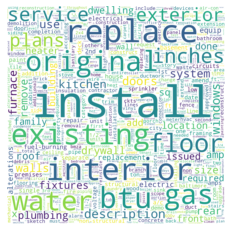

In [78]:
description_list_final = house_permit_from_file_filter['tokenized_final'].tolist()
word_list_final = []
for sublist in description_list_final:
    for word in sublist:
        word_list_final.append(word)
word_frequency_dict_final = FreqDist(word_list_final)
wordcloud_description_final = WordCloud(max_words = 1000,
                              width = 2000,
                              height = 2000,
                              background_color = 'white'
                             ).generate_from_frequencies(frequencies = word_frequency_dict_final)
plt.figure()
plt.imshow(wordcloud_description_final, interpolation='bilinear')
plt.axis('off')
wordcloud_description_final.to_file('house_permit_final.png')

In [129]:
df_word_frequency = pd.DataFrame(word_frequency_dict_final.items(),columns=['word','frequency'])
df_word_frequency = df_word_frequency.sort_values(by = 'frequency', ascending = False).reset_index()
# del df_word_frequency['index']
print(word_frequency_dict_final['demolish'])
print(word_frequency_dict_final['demolition'])

125
1894
88
12068


In [116]:
# Get demolition data
demolition_list = set(['demolish', 'demolition'])
mask = house_permit_value_filter['tokenized_final'].apply(lambda x: 'demolition' in x or 'demolish' in x) 
df_demolition = house_permit_value_filter[mask]
df_demolition = df_demolition[df_demolition['cost'].notnull()]
df_demolition['cost'] = df_demolition['cost'].astype(float)
df_demolition = df_demolition.sort_values(by = 'year', ascending = False)

In [120]:
df_demolition.head()

,address,lat,long,PIN,date,description,tokenized_final,cost,value,year
4659,2119 BARCLAY ST,39.314043,-76.611104,3814010,03/31/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, sf, in...",15000.0,5000.0,2020
4692,726 N CARROLLTON AVE,39.297523,-76.637209,0102014,04/02/2020,scope of work:--category i demolition--non-str...,"[scope, --, category, demolition, --, non-stru...",2500.0,17000.0,2020
4703,1714 E PRATT ST,39.289283,-76.592821,1744027,04/03/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, interi...",100.0,110900.0,2020
4738,2017 WESTWOOD AVE,39.308643,-76.650700,0006028A,04/07/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, interi...",7500.0,7000.0,2020
4746,3725 FOSTER AVE,39.284653,-76.565215,6444013,04/07/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, interi...",50000.0,176533.0,2020


In [127]:
demolition_over_time = px.scatter_mapbox(df_demolition,
                           lat = 'lat',
                           lon = 'long',
                           hover_name = 'address',
                           size = 'cost',
                           animation_frame = 'year',
                           center = dict(lat=39.2904, lon= -76.6122),
                           title = "Demolition over the time in Baltimore",
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max = 100,
                           zoom = 10,
                           )

In [128]:
demolition_over_time.write_html('demolition_over_time.html')

In [37]:
# This is for previous test

# description_list_updated = house_permit_from_file_filter['no_symbols'].tolist()
# word_list = []
# for sublist in description_list_updated:
#     for word in sublist:
#         word_list.append(word)
# word_frequency_dict = FreqDist(word_list)
# df_word_frequency = pd.DataFrame(word_frequency_dict.items(),columns=['word','frequency'])
# df_word_frequency = df_word_frequency.sort_values(by = 'frequency', ascending = False).reset_index()
# # del df_word_frequency['index']
# df_word_frequency.head(50)

(-0.5, 1999.5, 1999.5, -0.5)

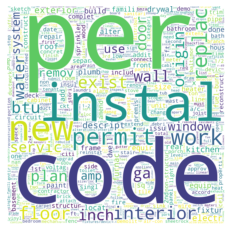

In [42]:
# wordcloud_description_updated = WordCloud(max_words = 1000,
#                               width = 2000,
#                               height = 2000,
#                               background_color = 'white'
#                              ).generate_from_frequencies(frequencies = word_frequency_dict)
# plt.figure()
# plt.imshow(wordcloud_description_updated, interpolation='bilinear')
# plt.axis('off')

In [43]:
# wordcloud_description_updated.to_file('house_permit.png')